# Intermittend Demand

## Croston's Method

Source: https://www.pmorgan.com.au/tutorials/crostons-method/

### Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ts = np.array([2,0,0,1,0,5,4,0,0,3,0,0,1,1])
print(ts)

[2 0 0 1 0 5 4 0 0 3 0 0 1 1]


Text(0, 0.5, 'Demand')

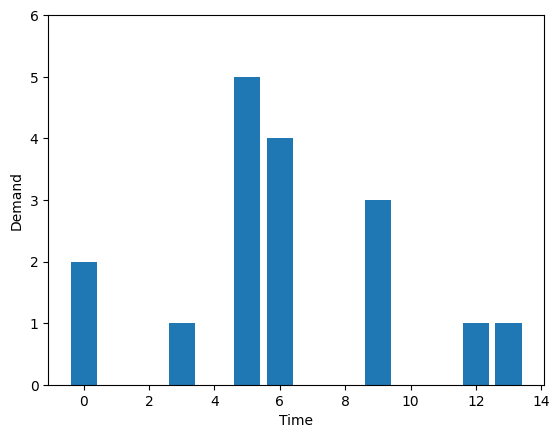

In [ ]:
plt.bar(np.arange(len(ts)), ts)
plt.ylim([0, 6])
plt.xlabel('Time')
plt.ylabel('Demand')

### Step 1: Non-zero series of demand

In [ ]:
z = ts[ts != 0]
print('Demand, z: ', z)

Demand, z:  [2 1 5 4 3 1 1]


### Step 2: Series of non-zero indices

In [ ]:
p_idx = np.flatnonzero(ts)
print('Index: ', p_idx)

Index:  [ 0  3  5  6  9 12 13]


In [ ]:
p = np.diff(p_idx, prepend=-1)
print('Period, p: ', p)

Period, p:  [1 3 2 1 3 3 1]


In [ ]:
np.mean(p)

2.0

### Step 3: SES on both series

$$
\Large
\hat{z_t} = \alpha z_{t-1} + (1-\alpha)\hat{z_{t-1}}
\\
\Large
\hat{p_t} = \alpha p_{t-1} + (1-\alpha)\hat{p_{t-1}}
$$

In [ ]:
alpha = 0.1
n = len(z)
z_hat = np.zeros(n)
p_hat = np.zeros(n)
z_hat[0] = z[0]
p_hat[0] = np.mean(p)

for i in range(1,n):
    z_hat[i] = alpha*z[i] + (1-alpha)*z_hat[i-1]
    p_hat[i] = alpha*p[i] + (1-alpha)*p_hat[i-1]

print('Smoothed Demand, z_hat: ', np.round(z_hat,2))
print('Smoothed Period, p_hat: ', np.round(p_hat,2))

Smoothed Demand, z_hat:  [2.   1.9  2.21 2.39 2.45 2.31 2.17]
Smoothed Period, p_hat:  [2.   2.1  2.09 1.98 2.08 2.17 2.06]


### Step 4: Forecast

$$
\Large
\hat{y_t} = \frac{\hat{z_t}}{\hat{p_t}}
$$

When making a forecast with Croston's method or one of it's adaptations, we are left with a single value which represents the demand rate. For example, a forecast of 0.5 doesn't mean we predict a sale of half a unit, but perhaps 5 units over the next 10 days.

In [ ]:
y_hat = z_hat / p_hat
print('Forecast: ', np.round(y_hat, 2))

Forecast:  [1.   0.9  1.06 1.21 1.18 1.06 1.06]


In [ ]:
m = len(ts) + 1
forecast = np.empty(m)
forecast[:] = np.nan
forecast[p_idx+1] = y_hat

# Forward fill missing values with previous forecast
for i in range(1,m):
    if np.isnan(forecast[i]):
        forecast[i] = forecast[i-1]

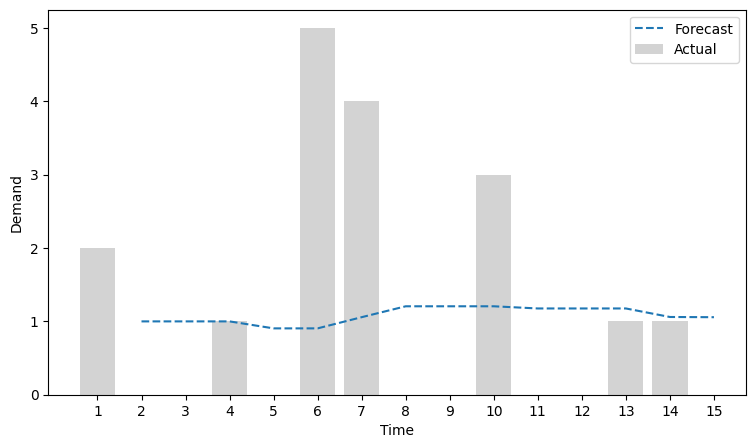

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
plt.bar(np.arange(1,m), ts, color='lightgrey', label='Actual')
plt.plot(np.arange(1,m+1), forecast, linestyle='--', label='Forecast')
plt.xticks(np.arange(1,m+1))
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

## Continuous Version

$$
\Large
\begin{array}
&& \hat{z_{t+1}} = \alpha z_{t} + (1-\alpha)\hat{z_{t}}
\\
\text{if y > 0 then} &\hat{p_{t+1}} = \alpha q + (1-\alpha)\hat{p_{t}}
\\
&q = 1
\end{array}
$$

$$
\Large
\begin{array}
&& \hat{z_{t+1}} = z_{t}
\\
\text{if y = 0 then} &\hat{p_{t+1}} = p_{t}
\\
&q = q + 1
\end{array}
$$

In [ ]:
def croston(ts, alpha=0.1):
    """
    Perform Croston's method on a time series, ts, and return
    a forecast

    Parameters
    ----------
    ts : (N,) array_like
        1-D input array
    alpha : float
        Smoothing factor, `0 < alpha < 1`, default = 0.1

    Returns
    -------
    forecast : (N+1,) ndarray
        1-D array of forecasted values, forecast begins 1-step
        after first non-zero demand in ts. Prefilled with np.nan.
    """

    # Initialise arrays for demand, z, and period, p. Starting
    # demand is first non-zero demand value, starting period is
    # mean of all intervals
    ts_trim = np.trim_zeros(ts, 'f')
    n = len(ts_trim)
    z = np.zeros(n)
    p = np.zeros(n)
    p_idx = np.flatnonzero(ts)
    p_diff = np.diff(p_idx, prepend=-1)
    p[0] = np.mean(p_diff)
    z[0] = ts[p_idx[0]]

    # Perform Croston's method
    q = 1
    for i in range(1,n):
        if ts_trim[i] > 0:
            z[i] = alpha*ts_trim[i] + (1-alpha)*z[i-1]
            p[i] = alpha*q + (1-alpha)*p[i-1]
            q = 1
        else:
            z[i] = z[i-1]
            p[i] = p[i-1]
            q += 1
    f = z / p
    nan_arr = [np.nan] * (len(ts)-n+1)
    return np.concatenate((nan_arr, f))

## Error Metrics

Source: https://www.pmorgan.com.au/tutorials/error-metrics-for-intermittent-demand-cfe,-pis,-msr/

### Cumulative Forecasting Error (CFE)

$$
\Large
\text{CFE} = \sum_{i=1}^t(y_t - \hat{y_t})
$$

A positive CFE means there was an under-estimation of the required stock during the period.

A negative number means an over-estimation.

### Number of Shortages (NOS)

The NOS is how many days that we were under-stocked throughout the period, which can be calculated by counting the number of positive CFE occurrences.

### Periods In Stock (PIS)

$$
\Large
\text{PIS} = -\sum_{i=1}^T\text{CFE}
$$

A positive PIS over a given period is an indication of being over-stocked.

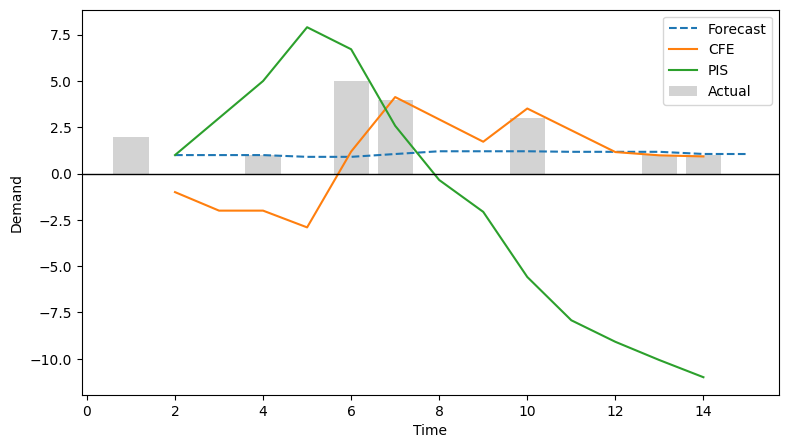

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example
demand = ts[1:]
CFE = np.cumsum(demand - forecast[1:-1])
PIS = -np.cumsum(CFE)

# Plot the results
fig, ax = plt.subplots(figsize=(9,5))
plt.bar(np.arange(1,m), ts, color='lightgrey', label='Actual')
plt.plot(np.arange(1,m+1), forecast, linestyle='--', label='Forecast')

plt.plot(np.arange(2,m), CFE, label='CFE')
plt.plot(np.arange(2,m), PIS, label='PIS')
plt.axhline(0, lw=1, color='black')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

While the CFE ends up back near zero, the PIS has dipped due to being under-stocked starting on t=6.

In [ ]:
from scipy.spatial.distance import sqeuclidean

def error(ts, forecast):
    """
    Return a dictionary of error metrics
    """
    cfe = np.cumsum(ts - forecast)
    cfe_max_idx = np.abs(cfe).argmax()
    pis = -np.cumsum(cfe)
    n = len(ts)
    d_rate = np.cumsum(ts) / np.arange(1,n+1)  # Demand rate
    trim = int(n*0.1)    # Number to trim from start of demand rate, ie 10%
    err = {
        'MAE': np.sum(np.abs(ts - forecast))/n,
        'MSE': sqeuclidean(ts, forecast)/n,
        'MSR': sqeuclidean(d_rate[trim:], forecast[trim:])/(n-trim),
        'CFE': cfe[-1],
        'CFE_MAX': np.max(cfe),
        'CFE_MIN': np.min(cfe),
        'NOS': len(cfe[cfe>0]),
        'PIS': pis[-1],
    }
    return err

In [ ]:
error(ts[1:], forecast[1:-1])

{'MAE': 1.28749383767412,
 'MSE': 2.8598177467301644,
 'MSR': 0.20534302726645434,
 'CFE': 0.9263105896633987,
 'CFE_MAX': 4.133059922533606,
 'CFE_MIN': -2.9047619047619047,
 'NOS': 9,
 'PIS': -10.996339506131733}

## Demand Rate

The Mean Squared Error is often used for cost functions, but when it comes to intermittent data it can prove to be problematic.

Due to all the zeros in the data, the error might be minimised by simply casting a forecast of zero, or one close to zero. On paper it looks great, we've reduced the error.

But in the real world it would translate to empty shelves. And you can't sell what you don't have.

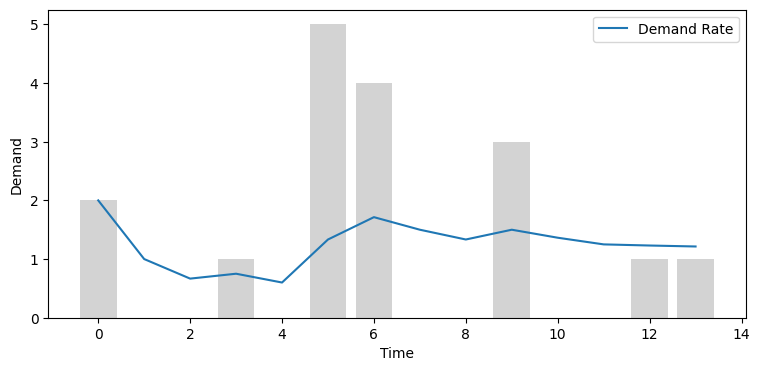

In [ ]:
# Example of demand rate
demand = ts
n = len(demand)
demand_rate = np.cumsum(demand) / np.arange(1,n+1)
# demand_rate = pd.Series(ts).expanding().mean()

fig, ax = plt.subplots(figsize=(9,4))
plt.bar(np.arange(0,n), demand, color='lightgrey')
plt.plot(demand_rate, label='Demand Rate')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

## Parameter Selection

Source: https://www.pmorgan.com.au/tutorials/error-metrics-for-intermittent-demand-cfe,-pis,-msr/

In [ ]:
import pandas as pd

alphas = np.arange(0,1.05,0.05)
df = pd.DataFrame([])

for a in alphas:
    forecast = croston(ts, alpha=a)
    idx = np.argmax(np.isfinite(forecast)) # Index of first non-NaN value
    err = error(ts[idx:], forecast[idx:-1])
    err = pd.DataFrame(err, index=[a])
    df = pd.concat([df, err], axis=0)

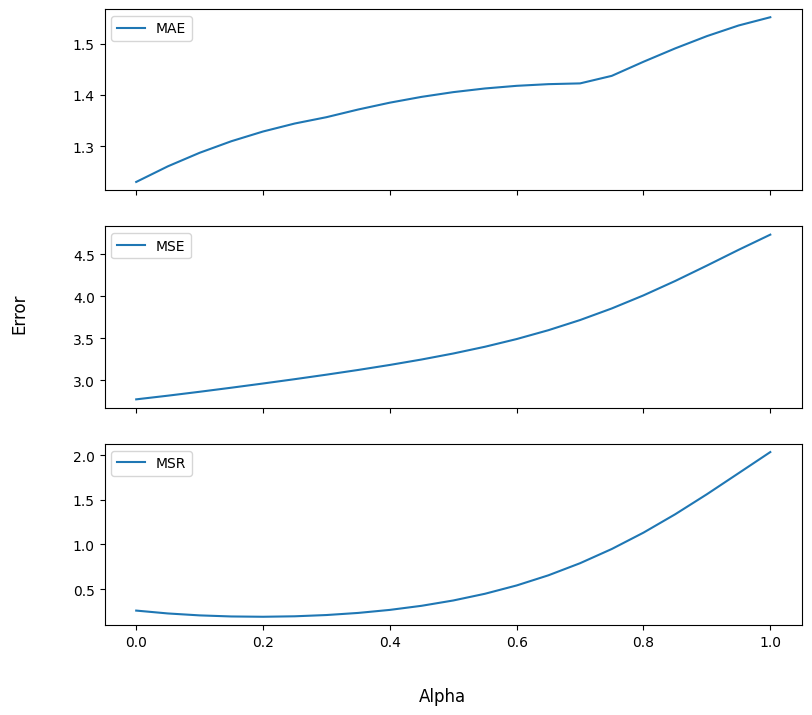

In [ ]:
metrics = ['MAE', 'MSE', 'MSR']
fig, axs = plt.subplots(nrows=3, figsize=(9,8), sharex=True)
for i, m in enumerate(metrics):
    df[m].plot(ax=axs[i], legend=m)
    axs[i].legend(loc="upper left")
fig.supxlabel('Alpha')
fig.supylabel('Error')
plt.show()

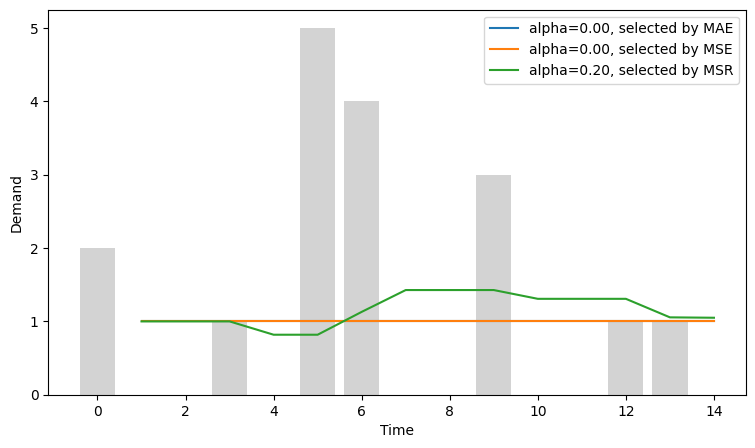

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
for m in metrics:
    alpha_min = df[m].abs().idxmin()
    forecast = croston(ts, alpha_min)
    l = f'alpha={alpha_min:.2f}, selected by {m}'
    plt.plot(forecast, label=l)
plt.bar(np.arange(len(ts)), ts, color='lightgrey')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

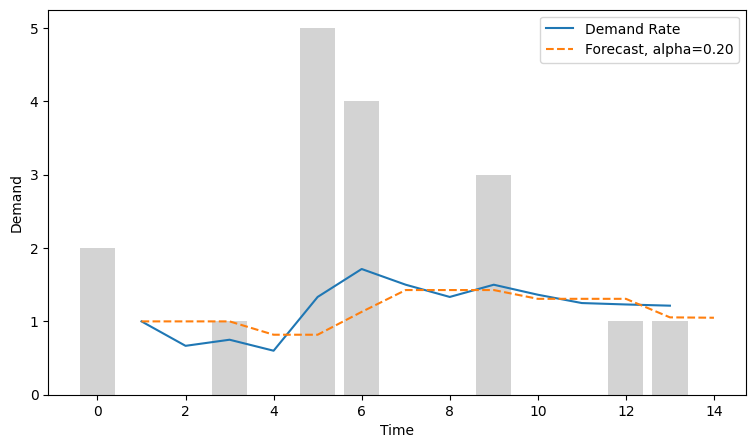

In [ ]:
# Construct demand rate array
d_rate = np.cumsum(ts) / np.arange(1,len(ts)+1)
trim = int(len(ts)*0.1)  # Trim % from the start of d_rate

# Plot results
alpha_min = df['MSR'].abs().idxmin()
fig, ax = plt.subplots(figsize=(9,5))
plt.bar(np.arange(len(ts)), ts, color='lightgrey')
plt.plot(np.arange(trim,len(ts)), d_rate[trim:],
         label='Demand Rate')
plt.plot(croston(ts, alpha_min), linestyle='--',
         label=f'Forecast, alpha={alpha_min:.2f}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

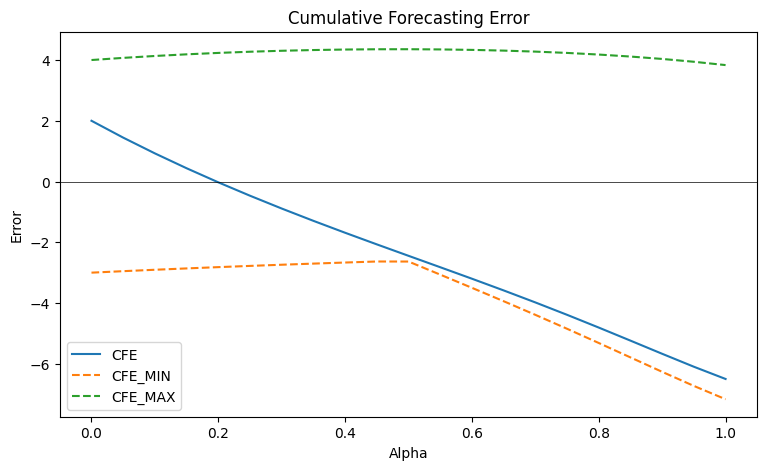

In [ ]:
fig, axs = plt.subplots(figsize=(9,5))
plt.plot(df['CFE'], label='CFE')
plt.plot(df['CFE_MIN'], linestyle='--', label='CFE_MIN')
plt.plot(df['CFE_MAX'], linestyle='--', label='CFE_MAX')
plt.axhline(linewidth=0.5, color='black')
plt.legend()
plt.title('Cumulative Forecasting Error')
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.show()

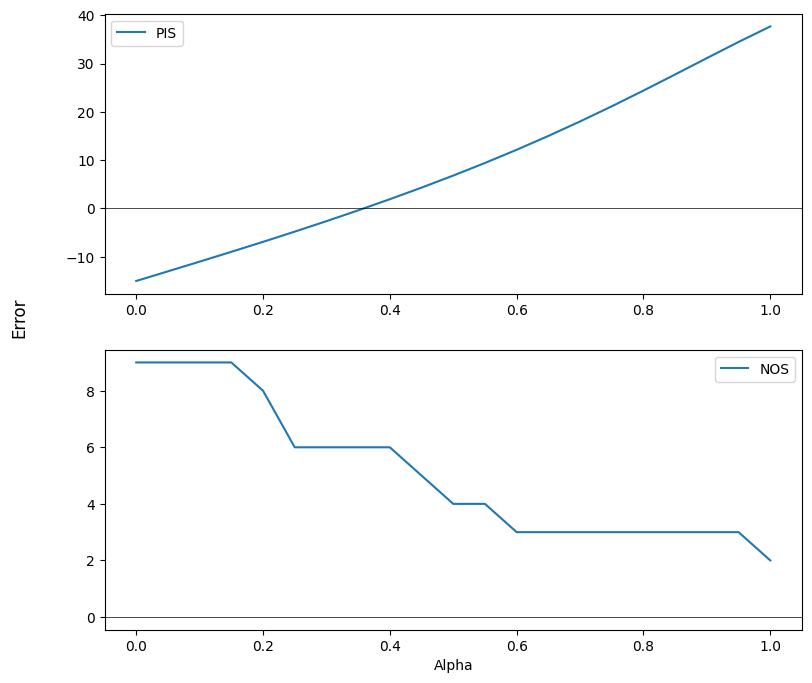

In [ ]:
metrics = ['PIS', 'NOS']
fig, axs = plt.subplots(nrows=2, figsize=(9,8))
for i, m in enumerate(metrics):
    axs[i].plot(df[m], label=m)
    axs[i].axhline(linewidth=0.5, color='black')
    axs[i].legend()
plt.xlabel('Alpha')
fig.supylabel('Error')
plt.show()

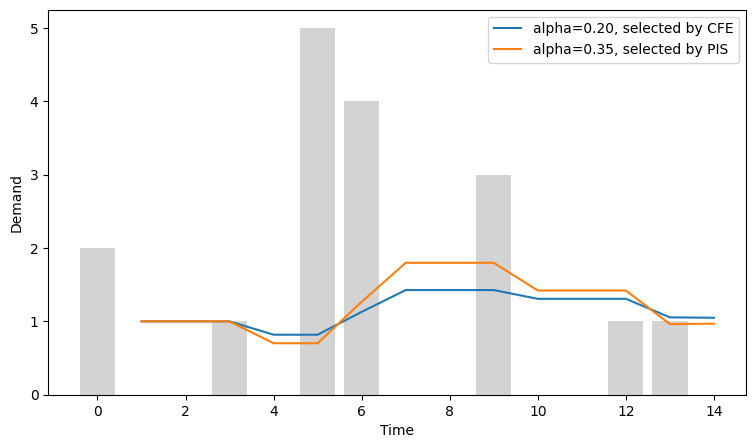

In [ ]:
metrics = ['CFE', 'PIS']
fig, ax = plt.subplots(figsize=(9,5))
for m in metrics:
    alpha_min = df[m].abs().idxmin()
    forecast = croston(ts, alpha_min)
    l = f'alpha={alpha_min:.2f}, selected by {m}'
    plt.plot(forecast, label=l)
plt.bar(np.arange(len(ts)), ts, color='lightgrey')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

## Croston Adaptations

Source: https://www.pmorgan.com.au/tutorials/adaptations-of-crostons-method/

### Syntetos-Boylan Approximation (SBA)

$$
\Large
\hat{y_t} = \left(1-\frac{\beta}{2}\right)\frac{\hat{z_t}}{\hat{p_t}}
$$

### Teunter-Syntetos-Babai Method (TSB)

$$
\Large
\text{if y > 0 then}
\\
\Large
\begin{array}
&& z_{t+1} = \alpha z_{t} + (1-\alpha)\hat{z_{t}}
\\
&p_{t+1} = \beta + (1-\beta)\hat{p_{t}}
\end{array}
$$

$$
\Large
\text{if y = 0 then}
\\
\Large
\begin{array}
&& z_{t+1} = z_{t}
\\
&p_{t+1} = (1-\beta)\hat{p_{t}}
\end{array}
$$

$$
\Large
\hat{y_{t+1}} = p_{t+1} \cdot z_{t+1}
$$

A nice feature of TSB is that the forecast continues to update even when there isn't a demand occurence (unlike Croston and SBA, which predict the same value indefinitely).

In [ ]:
def intmt_demand(ts, method='cro', alpha=0.1, beta=0.1):
    """
    Perform smoothing on an intermittent time series, ts, and return
    a forecast array

    Parameters
    ----------
    ts : (N,) array_like
        1-D input array
    method : {'cro', 'sba', 'tsb'}
        Forecasting method: Croston, Syntetos-Boylan Approximation
        and Teunter-Syntetos-Babai method
    alpha : float
        Demand smoothing factor, `0 < alpha < 1`, default = 0.1
    beta : float
        Interval smoothing factor, `0 < beta < 1`, default = 0.1

    Returns
    -------
    forecast : (N+1,) ndarray
        1-D array of forecasted values
    """
    # Initialise arrays for demand, z, and period, p. Starting
    # demand is first non-zero demand value, starting period is
    # mean of all demand intervals
    ts_trim = np.trim_zeros(ts, 'f')
    n = len(ts_trim)
    z = np.zeros(n)
    p = np.zeros(n)
    p_idx = np.flatnonzero(ts)
    p_diff = np.diff(p_idx, prepend=-1)
    p[0] = np.mean(p_diff)
    z[0] = ts[p_idx[0]]
    if method in {'cro', 'sba'}:
        q = 1
        for i in range(1,n):
            if ts_trim[i] > 0:
                z[i] = alpha*ts_trim[i] + (1-alpha)*z[i-1]
                p[i] = beta*q + (1-beta)*p[i-1]
                q = 1
            else:
                z[i] = z[i-1]
                p[i] = p[i-1]
                q += 1
        f = z / p
        if method == 'sba':
            f *= (1 - beta/2)
    elif method == 'tsb':
        p[0] = 1 / p[0]   # Change to probability of demand occurence
        for i in range(1,n):
            if ts_trim[i] > 0:
                z[i] = alpha*ts_trim[i] + (1-alpha)*z[i-1]
                p[i] = beta + (1-beta)*p[i-1]
            else:
                z[i] = z[i-1]
                p[i] = (1 - beta)*p[i-1]
        f = p * z
    nan_arr = [np.nan] * (len(ts)-n+1)
    return np.concatenate((nan_arr, f))

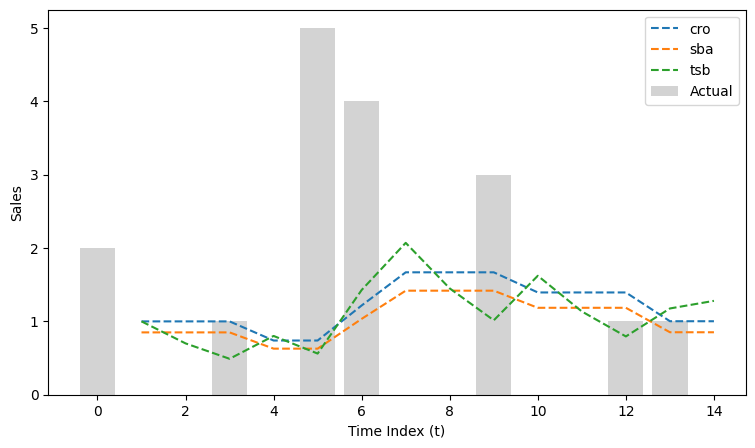

In [ ]:
alpha, beta = 0.3, 0.3
fig, ax = plt.subplots(figsize=(9,5))
plt.bar(np.arange(len(ts)), ts, color='lightgrey', label='Actual')
for m in ['cro', 'sba', 'tsb']:
    forecast = intmt_demand(ts, m, alpha, beta)
    plt.plot(forecast, linestyle='--', label=m)
plt.xlabel('Time Index (t)')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
def mae(ts, forecast):
    "Return mean absolute error of two numpy arrays"
    return np.mean(np.abs(ts - forecast))

def mse(ts, forecast):
    "Return mean squared error of two numpy arrays"
    return np.mean((ts - forecast)**2)

In [ ]:
from scipy.spatial.distance import sqeuclidean

def msr(ts, forecast):
    n = len(ts)
    d_rate = np.cumsum(ts) / np.arange(1,n+1)  # Demand rate
    trim = int(n*0.1)    # Number to trim from start of demand rate, ie 10%
    return sqeuclidean(d_rate[trim:], forecast[trim:])/(n-trim)

In [ ]:
from scipy.optimize import minimize

def min_error_func(params, ts, method, metric=mae):
    alpha, beta = params
    f = intmt_demand(ts, method=method, alpha=alpha, beta=beta)
    idx = np.argmax(np.isfinite(f))
    return metric(ts[idx:], f[idx:-1])

# Find optimal values for alpha, beta using the MSR as the
# error metric, and TSB as the forecasting model
init = [0.1,0.1]  # Initial guess for alpha, beta
tsb_opt = minimize(min_error_func, init,
                   args=(ts, 'tsb', msr),
                   bounds=[(0,1), (0,1)])
print(f'Optimal alpha: {tsb_opt.x[0]:.4f}')
print(f'Optimal beta: {tsb_opt.x[1]:.4f}')

Optimal alpha: 0.2655
Optimal beta: 0.1652


In [ ]:
sba_opt = minimize(min_error_func, init,
                   args=(ts, 'sba', msr),
                   bounds=[(0,1), (0,1)])
print(f'Optimal alpha: {sba_opt.x[0]:.4f}')
print(f'Optimal beta: {sba_opt.x[1]:.4f}')

Optimal alpha: 0.3277
Optimal beta: 0.2573


In [ ]:
cro_opt = minimize(min_error_func, init,
                   args=(ts, 'cro', msr),
                   bounds=[(0,1), (0,1)])
print(f'Optimal alpha: {cro_opt.x[0]:.4f}')
print(f'Optimal beta: {cro_opt.x[1]:.4f}')

Optimal alpha: 0.2049
Optimal beta: 0.1114


## pyInterDemand

https://github.com/Valdecy/pyInterDemand

In [ ]:
#!pip install pyInterDemand

In [ ]:
ts = np.array([2,0,0,1,0,5,4,0,0,3,0,0,1,1])
ts_dt = pd.Series(ts, index=pd.date_range('2024-07-01', '2024-07-14'))
ts_dt

2024-07-01    2
2024-07-02    0
2024-07-03    0
2024-07-04    1
2024-07-05    0
2024-07-06    5
2024-07-07    4
2024-07-08    0
2024-07-09    0
2024-07-10    3
2024-07-11    0
2024-07-12    0
2024-07-13    1
2024-07-14    1
Freq: D, dtype: int64

In [ ]:
from pyInterDemand.algorithm.intermittent import plot_int_demand, classification, mase, rmse
from pyInterDemand.algorithm.intermittent import croston_method

In [ ]:
def v_q_values(ts):
    v     = ts[ts > 0]
    q     = []
    count = 0
    for i, val in enumerate(ts):
        count = count + 1
        if (val > 0):
            q.append(count)
            count = 0
    return v, np.asarray(q)

def classification(ts):
    v, q         = v_q_values(ts)
    adi          = len(ts) / len(ts[ts > 0]) if len(ts[ts > 0]) > 0 else float('inf')
    cv_squared   = ( sum( ( (v - ts.mean() )**2)/ len(ts) )/ ts.mean() )
    f_type       = 'Smooth'
    if (adi > 1.32 and cv_squared < 0.49 ):
        f_type = 'Intermittent'
    elif (adi > 1.32 and cv_squared > 0.49 ):
        f_type = 'Lumpy'
    elif (adi < 1.32 and cv_squared > 0.49 ):
        f_type = 'Erratic'
    print('ADI: ', round(adi, 3), ', CV: ', round(cv_squared, 3), ', Type: ', f_type)
    return adi, cv_squared

ADI:  2.0 , CV:  1.532 , Type:  Lumpy


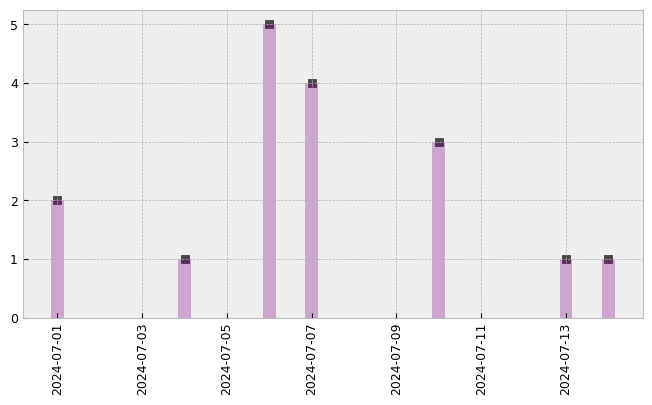

In [ ]:
# Time Series Classification
adi, cv_sq = classification(ts_dt)

# Time Series Plot
plot_int_demand(ts_dt, size_x = 8, size_y = 4, bar_width = 0.3)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Croston
v, q, forecast = croston_method(ts_dt, alpha = 0.5, n_steps = 4)

MASE =  0.946 , RMSE =  1.887


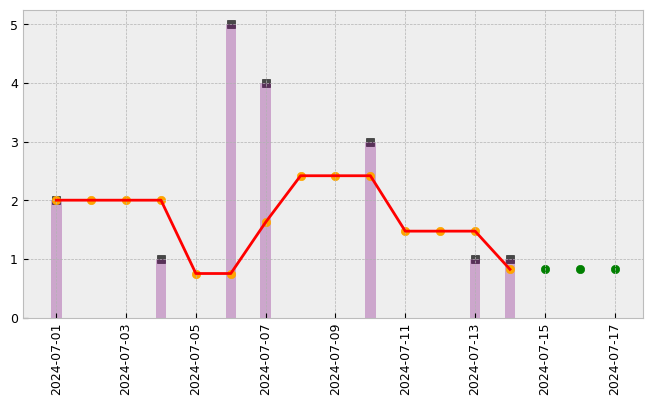

In [ ]:
plot_int_demand(ts_dt, size_x = 8, size_y = 4, bar_width = 0.3, prediction = forecast)
# Error
print('MASE = ', round(mase(ts, forecast), 3), ', RMSE = ', round(rmse(ts, forecast), 3))